In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
words = open('../names.txt', 'r').read().splitlines()
words[:2]

['emma', 'olivia']

In [ ]:
chars = ['.'] + sorted(set(''.join(words)))
stoi = {k:i for i, k in enumerate(chars)}
itos = {v:k for k, v in stoi.items()}

In [ ]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for word in words:
        context = [0] * block_size
    
        for w in word + '.':
            #print(contex, w)
            X.append(context)
            Y.append(stoi[w])
            #print(''.join(itos[i] for i in context), '--->', w)
            context = context[1:] + [stoi[w]]
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
n_emb = 10
n_hid = 100

g = torch.Generator().manual_seed(2147483647) 

C = torch.randn((27, n_emb), generator=g) # embedding matrix
W1 = torch.randn((block_size*n_emb, n_hid), generator=g) + (5/3)/((n_emb * block_size)**0.5)
b1 = torch.randn(n_hid, generator=g) * 0.1
W2 = torch.randn((n_hid, 27), generator=g) * 0.1
b2 = torch.randn(27, generator=g) * 0.1

#batch norm params
bngain = torch.ones((1, n_hid))
bnbias = torch.zeros((1, n_hid))
bnmean_running = torch.zeros((1, n_hid))
bnstd_running = torch.ones((1, n_hid))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad_(True)

In [ ]:
bs = 64
max_steps = 200000

In [ ]:
lossi = []

for i in range(max_steps):
    # mini batch 
    ix = torch.randint(0, Xtr.shape[0], (bs,))

    #forward pass
    emb = C[Xtr[ix]].view((bs, -1))              # shape: bs,-1
    hpreact = emb @ W1 + b1

    meanh = hpreact.mean(0, keepdims=True)
    stdh = hpreact.std(0, keepdims=True)

    hpreact = bngain * (hpreact - meanh) / stdh + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * meanh
        bnstd_running = 0.999 * bnstd_running + 0.001 * stdh
        
    h = torch.tanh((hpreact - meanh) / stdh ** 0.5)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None

    loss = F.cross_entropy(logits, Ytr[ix])
    
    
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for j, p in enumerate( parameters):
        #print(f"{i} -> {j} -> {p.dtype}")
        if p.grad != None:
            p.data += -lr * p.grad
            
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    lossi.append(loss.log10().item())
    #lri.append(i)

      0/ 200000: 3.1046
  10000/ 200000: 2.4248
  20000/ 200000: 2.5842
  30000/ 200000: 2.1845
  40000/ 200000: 2.2136
  50000/ 200000: 2.2015
  60000/ 200000: 2.2614
  70000/ 200000: 2.0720
  80000/ 200000: 2.2405
  90000/ 200000: 2.3199
 100000/ 200000: 2.2701
 110000/ 200000: 2.0353
 120000/ 200000: 2.0070
 130000/ 200000: 2.2685
 140000/ 200000: 1.9562
 150000/ 200000: 2.0166
 160000/ 200000: 1.8816
 170000/ 200000: 2.3388
 180000/ 200000: 2.1566
 190000/ 200000: 2.1687


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
    
    emb = C[x].view((x.shape[0], -1))
    
    hpreact = emb @ W1 + b1
    
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    
    h = torch.tanh((hpreact - meanh) / stdh ** 0.5)
    
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, y)

    print(f"{split} -> {loss.item():.4f}")

split_loss('train')
split_loss('val')
split_loss('test')

train -> 2.1576
val -> 2.1737
test -> 2.1738


#### with normal distribution 
- train -> 2.1441
- val -> 2.1700
- test -> 2.1665
### with scaled weight with gain
- train -> 2.1315
- val -> 2.1645
- test -> 2.1623
### with batch norm
- train -> 2.1576
- val -> 2.1737
- test -> 2.1738

Text(0, 0.5, 'loss')

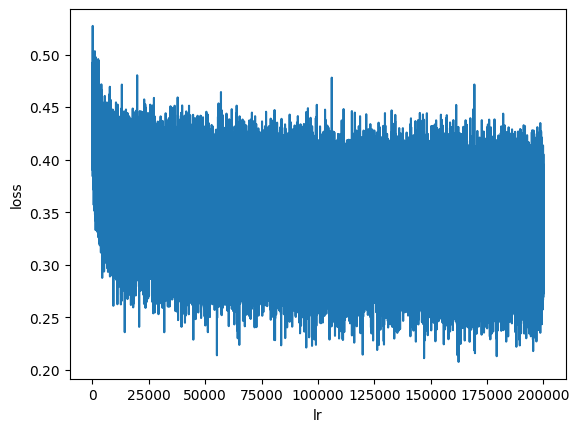

In [ ]:
plt.plot( lossi)
plt.xlabel('lr')
plt.ylabel('loss')

In [ ]:
arr = torch.randn((4, 5))
m, s = arr.mean(dim=1, keepdims=True), arr.std(dim=0, keepdims=True)
m.shape, s.shape

(torch.Size([4, 1]), torch.Size([1, 5]))

In [ ]:
arr - m

tensor([[-0.3535, -0.3503,  0.0237, -0.4563,  1.1364],
        [-0.5211,  0.7267,  0.1855, -0.5318,  0.1407],
        [-0.5376,  0.2490, -0.4445,  0.3028,  0.4303],
        [-0.4705,  0.2070,  0.9059,  0.2183, -0.8607]])